# Using Built-in Models

 @[Tianqiu Zhang](mailto:tianqiuakita@gmail.com) @[Chaoming Wang](mailto:adaduo@outlook.com)

BrainPy enables modularity programming and easy model debugging. To build a complex brain dynamics model, you just need to group its building blocks. In this section, we are going to talk about what building blocks we provide, and how to use these building blocks.


In [23]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

In [24]:
bp.__version__

'2.4.0'

## Initializing a neuron model

All neuron models implemented in brainpy are subclasses of ``brainpy.dyn.NeuGroup``. The initialization of a neuron model just needs to provide the geometry size of neurons in a population group.

In [25]:
hh = bp.neurons.HH(size=1)  # only 1 neuron

hh = bp.neurons.HH(size=10)  # 10 neurons in a group

hh = bp.neurons.HH(size=(10, 10))  # a grid of (10, 10) neurons in a group

hh = bp.neurons.HH(size=(5, 4, 2))  # a column of (5, 4, 2) neurons in a group

Generally speaking, there are two types of arguments can be set by users:

- **parameters**: the model parameters, like `gNa` refers to the maximum conductance of sodium channel in the ``brainpy.neurons.HH`` model.
- **variables**: the model variables, like `V` refers to the membrane potential of a neuron model.

In default, model *parameters* are homogeneous, which are just scalar values.

In [26]:
hh = bp.neurons.HH(5)  # there are five neurons in this group

hh.gNa

120.0

However, neuron models support heterogeneous parameters when performing computations in a neuron group. One can initialize *heterogeneous parameters* by several ways.

**1\. Array**

Users can directly provide an array as the parameter.

In [27]:
hh = bp.neurons.HH(5, gNa=bm.random.uniform(110, 130, size=5))

hh.gNa

Array(value=DeviceArray([129.84705, 114.92798, 128.4713 , 113.75466, 117.18596]), dtype=float32)

**2\. Initializer**

BrainPy provides wonderful supports on [initializations](../tutorial_toolbox/synaptic_weights.ipynb). One can provide an initializer to the parameter to instruct the model initialize heterogeneous parameters.

In [28]:
hh = bp.neurons.HH(5, ENa=bp.init.OneInit(50.))

hh.ENa

Array(value=DeviceArray([50., 50., 50., 50., 50.]), dtype=float32)

**3\. Callable function**

You can also directly provide a callable function which receive a ``shape`` argument.

In [29]:
hh = bp.neurons.HH(5, ENa=lambda shape: bm.random.uniform(40, 60, shape))

hh.ENa

Array(value=DeviceArray([44.32568 , 44.37094 , 58.253105, 49.798958, 47.053646]), dtype=float32)

Here, let's see how the heterogeneous parameters influence our model simulation.

In [30]:
# we create 3 neurons in a group. Each neuron has a unique "gNa"

model = bp.neurons.HH(3, gNa=bp.init.Uniform(min_val=100, max_val=140))

  0%|          | 0/1000 [00:00<?, ?it/s]

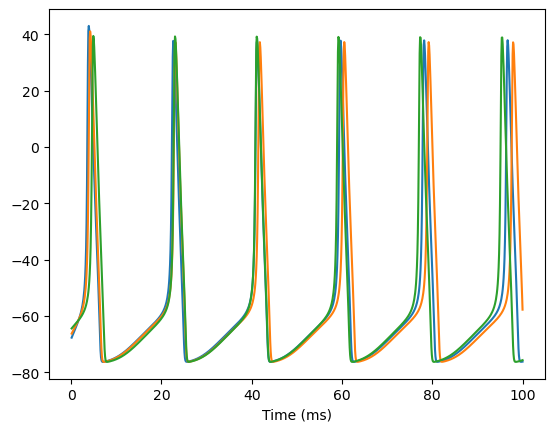

In [31]:
runner = bp.DSRunner(model, monitors=['V'], inputs=['input', 5.])
runner.run(100.)

bp.visualize.line_plot(runner.mon.ts, runner.mon.V, plot_ids=[0, 1, 2], show=True)

Similarly, the setting of the initial values of a variable can also be realized through the above three ways: *Array*, *Initializer*, and *Callable function*. For example,

In [32]:
hh = bp.neurons.HH(
   3,
   V_initializer=bp.init.Uniform(-80., -60.),  # Initializer
   m_initializer=lambda shape: bm.random.random(shape),  # function
   h_initializer=bm.random.random(3),  # Array
)

In [33]:
print('V: ', hh.V)
print('m: ', hh.m)
print('h: ', hh.h)

V:  Variable(value=DeviceArray([-76.43544 , -60.711292, -75.41474 ]), dtype=float32)
m:  Variable(value=DeviceArray([0.23095095, 0.23991263, 0.53833437]), dtype=float32)
h:  Variable(value=DeviceArray([0.06155241, 0.8954506 , 0.5496007 ]), dtype=float32)


## Initializing a synapse model

Initializing a synapse model needs to provide its pre-synaptic group (``pre``), post-synaptic group (``post``) and the connection method between them (``conn``). The below is an example to create an [Exponential synapse model](../apis/auto/dyn/generated/brainpy.dyn.synapses.ExpCUBA.rst):

In [34]:
neu = bp.neurons.LIF(10)

# here we create a synaptic projection within a population
syn = bp.synapses.Exponential(pre=neu, post=neu, conn=bp.conn.All2All())

BrainPy's build-in synapse models support **heterogeneous** synaptic weights and delay steps by using *Array*, *Initializer* and *Callable function*. For example,

In [35]:
syn = bp.synapses.Exponential(neu, neu, bp.conn.FixedProb(prob=0.1),
                              g_max=bp.init.Uniform(min_val=0.1, max_val=1.),
                              delay_step=lambda shape: bm.random.randint(10, 30, shape))

In [36]:
syn.g_max

Array(value=DeviceArray([0.24275585, 0.15260789, 0.2140102 , 0.6132134 , 0.2724214 ,
                         0.1348389 , 0.43819317, 0.7509942 , 0.33495387, 0.75233114],            dtype=float32),
      dtype=float32)

In [37]:
syn.delay_step

Array(value=DeviceArray([18, 16, 10, 19, 25, 11, 12, 28, 16, 21]), dtype=int32)

However, in BrainPy, the built-in synapse models only support homogenous synaptic parameters, like the time constant $\tau$. Users can [customize their synaptic models](./synapse_models.ipynb) when they want heterogeneous synaptic parameters.

Similar, the synaptic variables can be initialized heterogeneously by using *Array*, *Initializer*, and *Callable functions*.

## Changing model parameters during simulation

In BrainPy, all the dynamically changed variables (no matter it is changed inside or outside the jitted function) should be marked as ``brainpy.math.Variable``. BrainPy's built-in models also support modifying model parameters during simulation.

For example, if you want to fix the `gNa` in the first 100 ms simulation, and then try to decrease its value in the following simulations. In this case, we can provide the `gNa` as an instance of ``brainpy.math.Variable`` when initializing the model.

In [38]:
hh = bp.neurons.HH(5, gNa=bm.Variable(bm.asarray([120.])))

runner = bp.DSRunner(hh, monitors=['V'], inputs=['input', 5.])

  0%|          | 0/1000 [00:00<?, ?it/s]

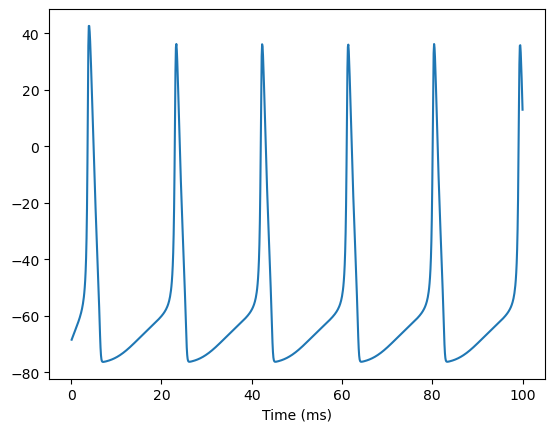

In [39]:
# the first running
runner.run(100.)
bp.visualize.line_plot(runner.mon.ts, runner.mon.V, show=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

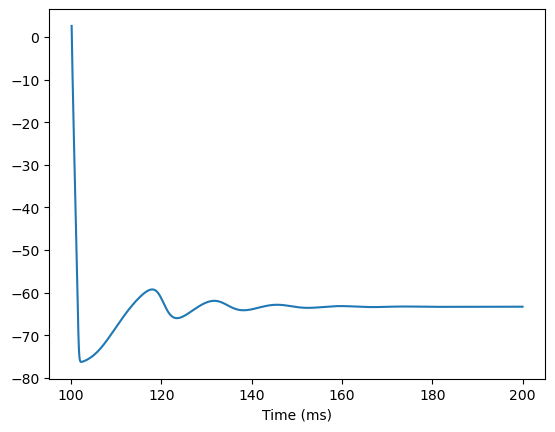

In [40]:
# change the gNa first
hh.gNa[:] = 100.

# the second running
runner.run(100.)
bp.visualize.line_plot(runner.mon.ts, runner.mon.V, show=True)

## Examples of using built-in models

Here we show users how to simulate a famous neuron models: [The Morris-Lecar neuron model](../apis/auto/dyn/generated/brainpy.dyn.neurons.MorrisLecar.rst), which is a two-dimensional "reduced" excitation model applicable to systems having two non-inactivating voltage-sensitive conductances.

In [41]:
group = bp.neurons.MorrisLecar(1)

Then users can utilize various tools provided by BrainPy to easily simulate the Morris-Lecar neuron model. Here we are not going to dive into details so please read the corresponding tutorials if you want to learn more.

  0%|          | 0/10000 [00:00<?, ?it/s]

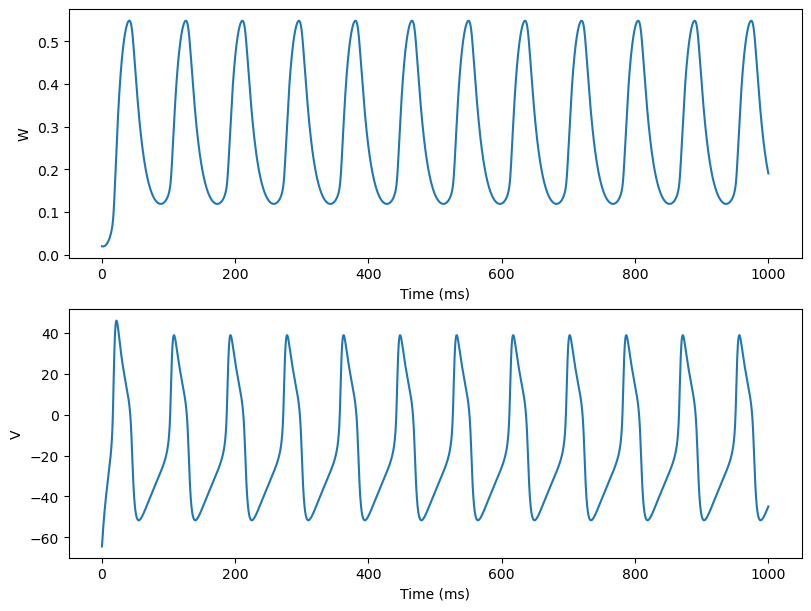

In [42]:
runner = bp.DSRunner(group, monitors=['V', 'W'], inputs=('input', 100.))
runner.run(1000)

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)
fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(runner.mon.ts, runner.mon.W, ylabel='W')
fig.add_subplot(gs[1, 0])
bp.visualize.line_plot(runner.mon.ts, runner.mon.V, ylabel='V', show=True)

Next we will also give users an intuitive understanding about building a network composed of different neurons and synapses model. Users can simply initialize these models as below and pass into ``brainpy.dyn.Network``.

In [43]:
neu1 = bp.neurons.HH(1)
neu2 = bp.neurons.HH(1)
syn1 = bp.synapses.AMPA(neu1, neu2, bp.connect.All2All())
net = bp.Network(pre=neu1, syn=syn1, post=neu2)

By selecting proper runner, users can simulate the network efficiently and plot the simulation results.

  0%|          | 0/1500 [00:00<?, ?it/s]

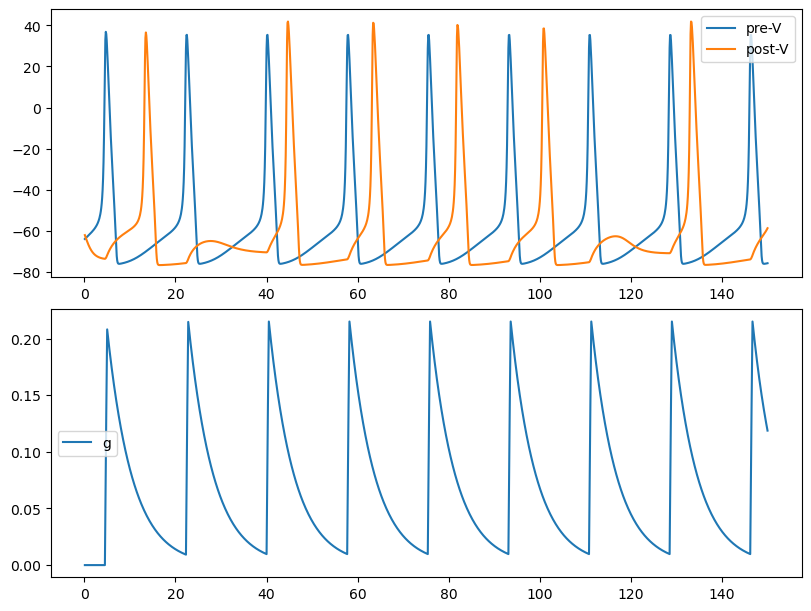

In [44]:
runner = bp.DSRunner(net,
                     inputs=(neu1.input, 6.),
                     monitors=['pre.V', 'post.V', 'syn.g'])
runner.run(150.)

import matplotlib.pyplot as plt

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)
fig.add_subplot(gs[0, 0])
plt.plot(runner.mon.ts, runner.mon['pre.V'], label='pre-V')
plt.plot(runner.mon.ts, runner.mon['post.V'], label='post-V')
plt.legend()

fig.add_subplot(gs[1, 0])
plt.plot(runner.mon.ts, runner.mon['syn.g'], label='g')
plt.legend()
plt.show()